# Image Captioning with Transformers
### Encoder-Decoder Architecture

<img src="../data/llm_architecture_comparison.png" width="600" align="center">
<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from tqdm.notebook import trange, tqdm
import random

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.distributions import Categorical

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision

import tensorflow as tf
import cv2 

# You'll need to install HugginFace's transformers library!
# https://huggingface.co/docs/transformers/en/index
# Make sure you are using the lastest version!
from transformers import AutoTokenizer
os.environ["TOKENIZERS_PARALLELISM"] = "false"

torch.backends.cuda.matmul.allow_tf32 = True

In [2]:
!pip install pycocotools

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 13.7 MB/s eta 0:00:00


In [3]:
!pip install gtts

In [4]:
from pycocotools.coco import COCO

In [5]:
# Define the learning rate for the optimizer
learning_rate = 1e-4

# Image size
image_size = 128

# Define the number of epochs for training
nepochs = 120

# Define the batch size for mini-batch gradient descent
batch_size = 128

# You'll need to download the COCO Captions dataset from the COCO Datsets
# https://cocodataset.org/#download
# For the Captions dataset you'll need to download:
# Images:
# 2014 Train images [83K/13GB]
# 2014 Val images [41K/6GB]
# Annotations:
# 2014 Train/Val annotations [241MB]

# Unzip them all into a directory called "coco_captions" and rename the folders
# train2014
# val2014
# annotations

# Define the root directory of the dataset
# data_set_root='../../datasets'
data_set_root ='/kaggle/input/coco-image-caption'
# train_set ='train2014'
train_set ='train2014/train2014'
# validation_set ='val2014'
validation_set = 'val2017/val2017'
train_image_path = os.path.join(data_set_root, train_set)
train_ann_file = '/kaggle/input/coco-image-caption/annotations_trainval2014/annotations/captions_train2014.json'
val_image_path = os.path.join(data_set_root, validation_set)
val_ann_file = '/kaggle/input/coco-image-caption/annotations_trainval2017/annotations/captions_val2017.json'

## Data processing and Tokenization

In [6]:
# Simple transform class to randomly sample one of the five captions
class SampleCaption(nn.Module):
    def __call__(self, sample):
        rand_index = random.randint(0, len(sample) - 1)
        return sample[rand_index]

In [7]:
train_transform = transforms.Compose([transforms.Resize(image_size),
                                      transforms.RandomCrop(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225]),
                                      transforms.RandomErasing(p=0.5)]) 

transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])]) 

train_dataset = datasets.CocoCaptions(root=train_image_path,
                                      annFile=train_ann_file,
                                      transform=train_transform,
                                      target_transform=SampleCaption())

val_dataset = datasets.CocoCaptions(root=val_image_path,
                                    annFile=val_ann_file,
                                    transform=transform,
                                    target_transform=SampleCaption())

data_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
data_loader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

loading annotations into memory...
Done (t=1.83s)
creating index...
index created!
loading annotations into memory...
Done (t=0.48s)
creating index...
index created!


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
# Create a dataloader itterable object
dataiter = next(iter(data_loader_val))
# Sample from the itterable object
test_images, test_captions = dataiter

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


A dusky evening with a green street light shining.


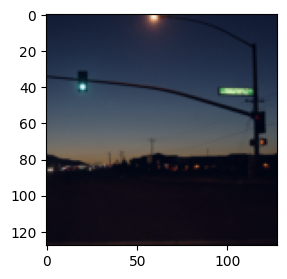

In [9]:
# Lets visualise an entire batch of images!
plt.figure(figsize = (3,3))
out = torchvision.utils.make_grid(test_images[0:1], 1, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

caption = test_captions[0]
print(caption)

In [10]:
# We'll use a pre-built Tokenizer for the BERT Model
# https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
tokenizer.vocab_size

30522

In [12]:
tokens = tokenizer(test_captions, padding=True, truncation=True, return_tensors="pt")

In [13]:
tokens['attention_mask']

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [14]:
token_ids = tokens['input_ids'][0]
tokens['input_ids']

tensor([[  101,  1037, 18406,  ...,     0,     0,     0],
        [  101,  3232,  1997,  ...,     0,     0,     0],
        [  101,  2273,  1999,  ...,     0,     0,     0],
        ...,
        [  101,  5723,  2007,  ...,     0,     0,     0],
        [  101,  1037,  2711,  ...,     0,     0,     0],
        [  101,  1037,  2388,  ...,     0,     0,     0]])

In [15]:
print(tokenizer.decode(token_ids))

[CLS] a dusky evening with a green street light shining. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [16]:
class TokenDrop(nn.Module):
    """For a batch of tokens indices, randomly replace a non-specical token.
    
    Args:
        prob (float): probability of dropping a token
        blank_token (int): index for the blank token
        num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """

    def __init__(self, prob=0.1, blank_token=1, eos_token=102):
        self.prob = prob
        self.eos_token = eos_token
        self.blank_token = blank_token

    def __call__(self, sample):
        # Randomly sample a bernoulli distribution with p=prob
        # to create a mask where 1 means we will replace that token
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()
        
        # only replace if the token is not the eos token
        can_drop = (~(sample == self.eos_token)).long()
        mask = mask * can_drop
        
        # Do not replace the sos tokens
        mask[:, 0] = torch.zeros_like(mask[:, 0]).long()
        
        replace_with = (self.blank_token * torch.ones_like(sample)).long()
        
        sample_out = (1 - mask) * sample + mask * replace_with
        
        return sample_out

## Create Encoder-Decoder Network

In [17]:
def extract_patches(image_tensor, patch_size=16):
    # Get the dimensions of the image tensor
    bs, c, h, w = image_tensor.size()
    
    # Define the Unfold layer with appropriate parameters
    unfold = torch.nn.Unfold(kernel_size=patch_size, stride=patch_size)
    
    # Apply Unfold to the image tensor
    unfolded = unfold(image_tensor)
    
    # Reshape the unfolded tensor to match the desired output shape
    # Output shape: BSxLxH, where L is the number of patches in each dimension
    unfolded = unfolded.transpose(1, 2).reshape(bs, -1, c * patch_size * patch_size)
    
    return unfolded

# sinusoidal positional embeds
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb
    

# Define a module for attention blocks
class AttentionBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, masking=True):
        super(AttentionBlock, self).__init__()
        self.masking = masking

        # Multi-head attention mechanism
        self.multihead_attn = nn.MultiheadAttention(hidden_size,
                                                    num_heads=num_heads,
                                                    batch_first=True,
                                                    dropout=0.0)

    def forward(self, x_in, kv_in, key_mask=None):
        # Apply causal masking if enabled
        if self.masking:
            bs, l, h = x_in.shape
            mask = torch.triu(torch.ones(l, l, device=x_in.device), 1).bool()
        else:
            mask = None
            
        # Perform multi-head attention operation
        return self.multihead_attn(x_in, kv_in, kv_in, attn_mask=mask, 
                                   key_padding_mask=key_mask)[0]


# Define a module for a transformer block with self-attention 
# and optional causal masking
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, decoder=False, masking=True):
        super(TransformerBlock, self).__init__()
        self.decoder = decoder

        # Layer normalization for the input
        self.norm1 = nn.LayerNorm(hidden_size)
        # Self-attention mechanism
        self.attn1 = AttentionBlock(hidden_size=hidden_size, num_heads=num_heads, 
                                    masking=masking)
        
        # Layer normalization for the output of the first attention layer
        if self.decoder:
            self.norm2 = nn.LayerNorm(hidden_size)
            # Self-attention mechanism for the decoder with no masking
            self.attn2 = AttentionBlock(hidden_size=hidden_size, 
                                        num_heads=num_heads, masking=False)
        
        # Layer normalization for the output before the MLP
        self.norm_mlp = nn.LayerNorm(hidden_size)
        # Multi-layer perceptron (MLP)
        self.mlp = nn.Sequential(nn.Linear(hidden_size, hidden_size * 4),
                                 nn.ELU(),
                                 nn.Linear(hidden_size * 4, hidden_size))
                
    def forward(self, x, input_key_mask=None, cross_key_mask=None, kv_cross=None):
        # Perform self-attention operation
        x = self.attn1(x, x, key_mask=input_key_mask) + x
        x = self.norm1(x)

        # If decoder, perform additional cross-attention layer
        if self.decoder:
            x = self.attn2(x, kv_cross, key_mask=cross_key_mask) + x
            x = self.norm2(x)

        # Apply MLP and layer normalization
        x = self.mlp(x) + x
        return self.norm_mlp(x)

    
# Define a decoder module for the Transformer architecture
class Decoder(nn.Module):
    def __init__(self, num_emb, hidden_size=128, num_layers=3, num_heads=4):
        super(Decoder, self).__init__()
        
        # Create an embedding layer for tokens
        self.embedding = nn.Embedding(num_emb, hidden_size)
        # Initialize the embedding weights
        torch.nn.init.normal_(self.embedding.weight, mean=0, std=0.01)

        # Initialize sinusoidal positional embeddings
        self.pos_emb = SinusoidalPosEmb(hidden_size)
        
        # Create multiple transformer blocks as layers
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads, 
                             decoder=True) for _ in range(num_layers)
        ])
                
        # Define a linear layer for output prediction
        self.fc_out = nn.Linear(hidden_size, num_emb)
        
    def forward(self, input_seq, encoder_output, input_padding_mask=None, 
                encoder_padding_mask=None):        
        # Embed the input sequence
        input_embs = self.embedding(input_seq)
        bs, l, h = input_embs.shape

        # Add positional embeddings to the input embeddings
        seq_indx = torch.arange(l, device=input_seq.device)
        pos_emb = self.pos_emb(seq_indx).reshape(1, l, h).expand(bs, l, h)
        embs = input_embs + pos_emb
        
        # Pass the embeddings through each transformer block
        for block in self.blocks:
            embs = block(embs, 
                           input_key_mask=input_padding_mask, 
                           cross_key_mask=encoder_padding_mask, 
                           kv_cross=encoder_output)
        
        return self.fc_out(embs)

    
# Define an Vision Encoder module for the Transformer architecture
class VisionEncoder(nn.Module):
    def __init__(self, image_size, channels_in, patch_size=16, hidden_size=128, 
                 num_layers=3, num_heads=4):
        super(VisionEncoder, self).__init__()
        
        self.patch_size = patch_size
        self.fc_in = nn.Linear(channels_in * patch_size * patch_size, hidden_size)
        
        seq_length = (image_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.empty(1, seq_length, 
                                                      hidden_size).normal_(std=0.02))
        
        # Create multiple transformer blocks as layers
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads, 
                             decoder=False, masking=False) for _ in range(num_layers)
        ])
                
    def forward(self, image):  
        bs = image.shape[0]

        patch_seq = extract_patches(image, patch_size=self.patch_size)
        patch_emb = self.fc_in(patch_seq)

        # Add a unique embedding to each token embedding
        embs = patch_emb + self.pos_embedding
        
        # Pass the embeddings through each transformer block
        for block in self.blocks:
            embs = block(embs)
        
        return embs
    
    
# Define an Vision Encoder-Decoder module for the Transformer architecture
class VisionEncoderDecoder(nn.Module):
    def __init__(self, image_size, channels_in, num_emb, patch_size=16, 
                 hidden_size=128, num_layers=(3, 3), num_heads=4):
        super(VisionEncoderDecoder, self).__init__()
        
        # Create an encoder and decoder with specified parameters
        self.encoder = VisionEncoder(image_size=image_size, channels_in=channels_in, 
                                     patch_size=patch_size, hidden_size=hidden_size, 
                                     num_layers=num_layers[0], num_heads=num_heads)
        
        self.decoder = Decoder(num_emb=num_emb, hidden_size=hidden_size, 
                               num_layers=num_layers[1], num_heads=num_heads)

    def forward(self, input_image, target_seq, padding_mask):
        # Generate padding masks for the target sequence
        bool_padding_mask = padding_mask == 0

        # Encode the input sequence
        encoded_seq = self.encoder(image=input_image)
        
        # Decode the target sequence using the encoded sequence
        decoded_seq = self.decoder(input_seq=target_seq, 
                                   encoder_output=encoded_seq, 
                                   input_padding_mask=bool_padding_mask)
        return decoded_seq

## Initialise Model and Optimizer

In [18]:
# Check if GPU is available, set device accordingly
device = torch.device(1 if torch.cuda.is_available() else 'cpu')

# Embedding Size
hidden_size = 192

# Number of Transformer blocks for the (Encoder, Decoder)
num_layers = (6, 6)

# MultiheadAttention Heads
num_heads = 8

# Size of the patches
patch_size = 8

# Create model
caption_model = VisionEncoderDecoder(image_size=image_size, channels_in=test_images.shape[1], 
                                     num_emb=tokenizer.vocab_size, patch_size=patch_size, 
                                     num_layers=num_layers,hidden_size=hidden_size, 
                                     num_heads=num_heads).to(device)

# Initialize the optimizer with above parameters
optimizer = optim.Adam(caption_model.parameters(), lr=learning_rate)

scaler = torch.cuda.amp.GradScaler()

# Define the loss function
loss_fn = nn.CrossEntropyLoss(reduction="none")

td = TokenDrop(0.5)

# Initialize the training loss logger
training_loss_logger = []

/tmp/ipykernel_30/2644528759.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [19]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in caption_model.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 18067194 (Approximately 18 Million) Parameters!


## Training

In [399]:
# Directory to save the model checkpoints
checkpoint_dir = "/kaggle/working/"
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in trange(0, nepochs, leave=False, desc="Epoch"):
    # Set the model in training mode
    caption_model.train()
    steps = 0
    # Iterate over the training data loader
    for images, captions in tqdm(data_loader_train, desc="Training", leave=False):
        
        images = images.to(device)
        
        # Tokenize and pre-process the captions
        tokens = tokenizer(captions, padding=True, truncation=True, return_tensors="pt")
        token_ids = tokens['input_ids'].to(device)
        padding_mask = tokens['attention_mask'].to(device)
        bs = token_ids.shape[0]
        
        # Shift the input sequence to create the target sequence
        target_ids = torch.cat((token_ids[:, 1:], 
                                torch.zeros(bs, 1, device=device).long()), 1)
        
        tokens_in = td(token_ids)
        with torch.cuda.amp.autocast():
            # Forward pass
            pred = caption_model(images, tokens_in, padding_mask=padding_mask)

        # Compute the loss
        loss = (loss_fn(pred.transpose(1, 2), target_ids) * padding_mask).mean()

        # Backpropagation
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Log the training loss
        training_loss_logger.append(loss.item())

    # Save model checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"caption_model_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': caption_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scaler_state_dict': scaler.state_dict(),
            'loss': loss.item(),
        }, checkpoint_path)
        print(f"Model checkpoint saved at epoch {epoch + 1} to {checkpoint_path}")


Epoch:   0%|          | 0/120 [00:00<?, ?it/s]

Training:   0%|          | 0/647 [00:00<?, ?it/s]

/tmp/ipykernel_30/2900425380.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79170862a680>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1441, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/opt/conda/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/opt/conda/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/opt/conda/li

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

## Plot Loss

In [ ]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(training_loss_logger[100:])
_ = plt.title("Training Loss")

In [ ]:
window_size = 512
data = np.convolve(np.array(training_loss_logger), np.ones(window_size)/window_size, mode="valid")
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(data[:])
_ = plt.title("Training Loss")

## Testing

In [20]:
model_path = '/kaggle/input/image-captioning-120/caption_model_epoch_120.pth'
checkpoint = torch.load(model_path)

caption_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scaler.load_state_dict(checkpoint['scaler_state_dict'])

/tmp/ipykernel_30/2101928603.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


In [21]:
# Define image size and normalization values according to the training process.
IMAGE_SIZE = (128, 128)  # Resize images to match the input size of your model (e.g., for InceptionV3).
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

def preprocess_image(image_path):
    # Load image file
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    
    # Resize the image to the required size
    image = tf.image.resize(image, IMAGE_SIZE)
    
    # Convert to [0, 1] range
    image = image / 255.0
    
    # Normalize using the mean and standard deviation values
    image = (image - MEAN) / STD
    
    # Add a batch dimension
    image = tf.expand_dims(image, axis=0)
    
    image = image.numpy()
    
    image = torch.from_numpy(image)
    
    image = image.permute(0,3,1,2)
    
    return image

In [22]:
# Define image size and normalization values according to the training process.
IMAGE_SIZE = (128, 128)  # Resize images to match the input size of your model.
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

def preprocess_vid(frame):
    # Ensure the frame is in float32 format for normalization
    frame = tf.convert_to_tensor(frame, dtype=tf.float32)

    # Resize the frame to the required size
    frame = tf.image.resize(frame, IMAGE_SIZE)

    # Convert pixel values to [0, 1] range
    frame = frame / 255.0

    # Normalize using mean and standard deviation values
    frame = (frame - MEAN) / STD

    # Add a batch dimension
    frame = tf.expand_dims(frame, axis=0)

    # Convert to NumPy, then to a PyTorch tensor
    frame = frame.numpy()
    frame = torch.from_numpy(frame)

    # Rearrange dimensions to match PyTorch's format (batch, channels, height, width)
    frame = frame.permute(0, 3, 1, 2)

    return frame

In [23]:
def display(image_path):

    image = cv2.imread(image_path)
    
    if image is None:
        print(f"Error: Unable to load image at {image_path}")
        return
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

In [24]:
def test(test_image):
    # Add the Start-Of-Sentence token to the prompt to signal the network to start generating the caption
    sos_token = 101 * torch.ones(1, 1).long()

    # Set the temperature for sampling during generation
    temp = 1.0

    log_tokens = [sos_token]
    caption_model.eval()
    torch.set_grad_enabled(False)
    
    with torch.no_grad():
        # Encode the input image
        with torch.cuda.amp.autocast():
            # Forward pass
            image_embedding = caption_model.encoder(test_image.to(device))

        # Generate the answer tokens
        for i in range(50):
            input_tokens = torch.cat(log_tokens, 1)

            # Decode the input tokens into the next predicted tokens
            data_pred = caption_model.decoder(input_tokens.to(device), image_embedding)
    
            if torch.isnan(data_pred).any():
                continue
    
            # Sample from the distribution of predicted probabilities
            clipped_logits = torch.clamp(data_pred[:, -1], min=-100, max=100)
            dist = Categorical(logits=clipped_logits / temp)
#             dist = Categorical(logits=data_pred[:, -1] / temp)
            next_tokens = dist.sample().reshape(1, 1)

            # Append the next predicted token to the sequence
            log_tokens.append(next_tokens.cpu())

            # Break the loop if the End-Of-Caption token is predicted
            if next_tokens.item() == 102:
                break
                
    # Convert the list of token indices to a tensor
    pred_text = torch.cat(log_tokens, 1)

    # Convert the token indices to their corresponding strings using the vocabulary
    pred_text_strings = tokenizer.decode(pred_text[0], skip_special_tokens=True)

    # Join the token strings to form the predicted text
    pred_text = "".join(pred_text_strings)

    # Print the predicted text
    print(pred_text)
    
    return pred_text

In [2]:
folder_path = '/kaggle/input/random-images'

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    test_image = preprocess_image(file_path).to(device)
    test(test_image)
    display(file_path)

NameError: name 'preprocess_image' is not defined

/tmp/ipykernel_30/210989696.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


a bottle with paints, scissors,, markers on a pencil.


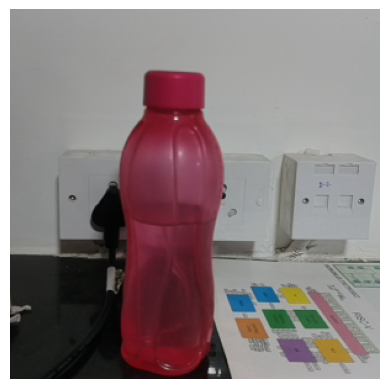

In [30]:
file_path = "/kaggle/input/oakd-image/OAKD.png"
test_image = preprocess_image(file_path).to(device)
ans = test(test_image)
display(file_path)

In [34]:
from gtts import gTTS
import os

# Text to be converted to speech
text = ans

# Language of the speech
language = 'en'  # Use 'en' for English, or any language code like 'es', 'fr', etc.

# Create gTTS object
tts = gTTS(text=text, lang=language, slow=False)  # slow=False for normal speed

# Save the audio file
tts.save("output.mp3")

# Play the audio (for Windows/macOS/Linux with default audio player)
os.system("start output.mp3")  # Use 'xdg-open' for Linux or 'open' for macOS


sh: 1: start: not found


32512

In [72]:
input_video_path = '/kaggle/input/test-video-cycling/Cycling.mp4'
cap = cv2.VideoCapture(input_video_path)

if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

i = 0

while True:
    # Read a frame from the video
    ret, frame = cap.read()
    i += 1
    if not ret:
        break  # Exit loop if no frame is read

    if i % 5 == 0:
        frame = preprocess_vid(frame).to(device)

        # Preprocess the frame (e.g., convert to tensor and normalize if required)
        test(frame)

/tmp/ipykernel_30/4089330330.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


several bottles of different colored scissors in a blue toilet.
person in a purple jacket holding a green frisbee.
bicycle and bicycle locked to a store display store and a tropical display.
pointing upwards, going tennis waves on the ball and a demon image.
a number of baseball bats laying on top of each other
a sign on the side of the road during the cell
an elderly man in a jail cell route and music on his head.
a bunch of street signs mounted to a wall.
signs on a tree beside the pedestrian street sign.
as a tall saying va walks up from a bunch of speakers
three ties on them are hooks for different colors.
##gr machines exactly manuals, keys, pencils, and computer mouse
